# Training Hand Recognition with Mediapipe and ML

This code is for training machine learning model with Google Mediapipe for hand recognition.  
In this code, the following methodology appears; XGB and LGBM Classifier.  
There are some libraries to run this code on the first cell, so please check it.  
It is recommend to run the code with Jupyter Notebook. Run each cell in order.  

- Recommend IDE: Jupyter Notebook, Visual Sutdio Code
- Language: **Python 3.10**

## 1. Import and Load Dataset

In [1]:
# Basic libraries 
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# For models 
from lightgbm import LGBMClassifier
from lightgbm import plot_importance 
from xgboost import XGBClassifier
from xgboost import plot_importance

# For training and evaluation 
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

C:\Users\mtang\anaconda3\envs\mp\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Get a current path 
# Configuration: set the path where dataset exists and dataset name
path = os.getcwd() + "/Dataset/HAND/Dataset1201_small/"
print(path) # for checking 

# Load hand gesture coordinates dataset 
# Original each data => data_0n (6300 x 8)
# N of data_0n => dataset (8 x 6300 x 8)
data_01 = pd.read_csv(path+"Dataset01/gesture01.csv", index_col=0) # path + config 
data_02 = pd.read_csv(path+"Dataset02/gesture02.csv", index_col=0) 
data_03 = pd.read_csv(path+"Dataset03/gesture03.csv", index_col=0)
data_04 = pd.read_csv(path+"Dataset04/gesture04.csv", index_col=0)
data_05 = pd.read_csv(path+"Dataset05/gesture05.csv", index_col=0)
data_06 = pd.read_csv(path+"Dataset06/gesture06.csv", index_col=0)
data_07 = pd.read_csv(path+"Dataset07/gesture07.csv", index_col=0)
data_08 = pd.read_csv(path+"Dataset08/gesture08.csv", index_col=0)
dataset = [data_01, data_02, data_03, data_04,
           data_05, data_06, data_07, data_08]

# Check the dataset 
dataset[0]

C:\Users\mtang\Desktop\SW\@KSW Gangsture\dolphin/Dataset/HAND/Dataset1201_small/


,0,1,2,3,4,0.1,1.1,2.1
0,HandLandmark.WRIST,Right,0.677059,0.657476,-9.620642e-08,0.000000,0.000000,0.000000
1,HandLandmark.THUMB_CMC,Right,0.652918,0.624900,-2.916028e-03,-0.024140,-0.032577,-0.002916
2,HandLandmark.THUMB_MCP,Right,0.641167,0.596705,-1.113892e-02,-0.035892,-0.060771,-0.011139
3,HandLandmark.THUMB_IP,Right,0.632429,0.579818,-2.165792e-02,-0.044629,-0.077658,-0.021658
4,HandLandmark.THUMB_TIP,Right,0.627184,0.567665,-3.225595e-02,-0.049875,-0.089812,-0.032256
...,...,...,...,...,...,...,...,...
6295,HandLandmark.RING_FINGER_TIP,Left,0.334333,0.475396,-2.431388e-02,0.029973,-0.061278,-0.024314
6296,HandLandmark.PINKY_MCP,Left,0.297858,0.462008,-2.820650e-02,-0.006501,-0.074666,-0.028207
6297,HandLandmark.PINKY_PIP,Left,0.332346,0.459900,-3.567721e-02,0.027987,-0.076774,-0.035677
6298,HandLandmark.PINKY_DIP,Left,0.336258,0.477074,-3.037439e-02,0.031899,-0.059600,-0.030374


## 2. Preprocessing

In this section, there are some steps for preprocessing of hand coordinates dataset. 

- data -> processed_data
- right: 0, left: 1
- landmark: 0~20, total 21

In [7]:
def preprocessed_data(data, y) :
    # Rename columns 
    data = data.rename(columns={"1":"hand_type", "2":"1_x", "3":"1_y", "4":"1_z", "0.1":"1_rx", "1.1":"1_ry", "2.1":"1_rz"})
 
    # Drop unnecessary column: landmark name 
    data = data.drop(['0'], axis=1)
        
    # Mapping hand type: right and left 
    data['hand_type'] = data['hand_type'].replace({'Right': 0, 'Left': 1})
    
    # Concating y value at the end of columns 
    data['label'] = y 
    
    # Add new columns 
    new_cols = []
    for i in range(2, 22) :
        new_cols = new_cols + [str(i)+"_x", str(i)+"_y", str(i)+"_z", str(i)+"_rx", str(i)+"_ry", str(i)+"_rz"]
    data_new = pd.DataFrame(columns=new_cols)
    data = pd.concat([data, data_new])
    
    # Insert values at new columns 
    for i in range(0, len(data)-20, 21) :
        for j in range(1, 21) :
            col_list = []
            col_list = [str(j+1)+"_x", str(j+1)+"_y", str(j+1)+"_z", str(j+1)+"_rx", str(j+1)+"_ry", str(j+1)+"_rz"]
            data.loc[i, col_list] = data.loc[i+j, ["1_x", "1_y", "1_z", "1_rx", "1_ry", "1_rz"]].values
            
    # Remove values at axis 0 
    remove_cols = []
    for i in range (len(data)) : 
        if i%21!=0 :
            remove_cols.append(i)
    data = data.drop(data.index[remove_cols]).reset_index(drop=True)

    # Convert dtypes 
    data[new_cols] = data[new_cols].astype(float)
    
    return data  

In [8]:
# N of original data_0n => dataset (8 x 6300 x 8)
# N of preprocessed data_0n => processed_dataset (8 x 300 x 128)
processed_dataset = []
for i in range(len(dataset)) :
    processed_data = preprocessed_data(dataset[i], i)
    processed_dataset.append(processed_data)
    
# Check the preprocessed data from processed_dataset
processed_dataset[0]

,hand_type,1_x,1_y,1_z,1_rx,1_ry,1_rz,label,2_x,2_y,...,20_z,20_rx,20_ry,20_rz,21_x,21_y,21_z,21_rx,21_ry,21_rz
0,0.0,0.677059,0.657476,-9.620642e-08,0.0,0.0,0.0,0.0,0.652918,0.624900,...,-0.035730,-0.026092,-0.040696,-0.035730,0.658362,0.619894,-0.030380,-0.018697,-0.037582,-0.030380
1,0.0,0.677106,0.657253,-9.645818e-08,0.0,0.0,0.0,0.0,0.652829,0.624553,...,-0.036874,-0.026049,-0.039856,-0.036874,0.658736,0.620634,-0.031373,-0.018369,-0.036620,-0.031373
2,0.0,0.675145,0.657782,-9.982320e-08,0.0,0.0,0.0,0.0,0.651108,0.624542,...,-0.036231,-0.023397,-0.039447,-0.036231,0.659437,0.621590,-0.030871,-0.015708,-0.036193,-0.030871
3,0.0,0.674169,0.658014,-9.233571e-08,0.0,0.0,0.0,0.0,0.649775,0.623340,...,-0.038262,-0.025393,-0.040459,-0.038262,0.657668,0.620659,-0.033143,-0.016501,-0.037355,-0.033143
4,0.0,0.673027,0.657437,-9.038089e-08,0.0,0.0,0.0,0.0,0.648304,0.623216,...,-0.039230,-0.025304,-0.040177,-0.039230,0.656682,0.620151,-0.033787,-0.016345,-0.037286,-0.033787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1.0,0.289268,0.505723,4.313853e-10,0.0,0.0,0.0,0.0,0.316801,0.478273,...,-0.027661,0.022524,-0.060114,-0.027661,0.306644,0.456133,-0.022163,0.017376,-0.049590,-0.022163
296,1.0,0.305319,0.544845,3.379597e-08,0.0,0.0,0.0,0.0,0.336319,0.514474,...,-0.033500,0.027090,-0.057781,-0.033500,0.327381,0.497466,-0.027634,0.022063,-0.047380,-0.027634
297,1.0,0.323038,0.550514,4.349930e-08,0.0,0.0,0.0,0.0,0.357628,0.519543,...,-0.033275,0.038405,-0.062673,-0.033276,0.353684,0.497975,-0.028081,0.030646,-0.052538,-0.028081
298,1.0,0.352546,0.535592,4.881541e-08,0.0,0.0,0.0,0.0,0.385564,0.503544,...,-0.030273,0.041595,-0.057979,-0.030273,0.388968,0.488536,-0.024997,0.036422,-0.047056,-0.024997


## 3. Prepare Input Data

Reshape as input data format.  
Split train and test dataset (8:2) for performance testing.  
Split train and valid dataset (8:2) for training validation.

In [9]:
# Reshpae as single input data
# N of preprocessed data_0n => processed_dataset (8 x 300 x 128)
# Single input data => input_data (2400 x 128)
input_data = processed_dataset[0]
for i in range (1, len(processed_dataset)) :
    input_data = pd.concat([input_data, processed_dataset[i]], ignore_index = True)
input_data

,hand_type,1_x,1_y,1_z,1_rx,1_ry,1_rz,label,2_x,2_y,...,20_z,20_rx,20_ry,20_rz,21_x,21_y,21_z,21_rx,21_ry,21_rz
0,0.0,0.677059,0.657476,-9.620642e-08,0.0,0.0,0.0,0.0,0.652918,0.624900,...,-0.035730,-0.026092,-0.040696,-0.035730,0.658362,0.619894,-0.030380,-0.018697,-0.037582,-0.030380
1,0.0,0.677106,0.657253,-9.645818e-08,0.0,0.0,0.0,0.0,0.652829,0.624553,...,-0.036874,-0.026049,-0.039856,-0.036874,0.658736,0.620634,-0.031373,-0.018369,-0.036620,-0.031373
2,0.0,0.675145,0.657782,-9.982320e-08,0.0,0.0,0.0,0.0,0.651108,0.624542,...,-0.036231,-0.023397,-0.039447,-0.036231,0.659437,0.621590,-0.030871,-0.015708,-0.036193,-0.030871
3,0.0,0.674169,0.658014,-9.233571e-08,0.0,0.0,0.0,0.0,0.649775,0.623340,...,-0.038262,-0.025393,-0.040459,-0.038262,0.657668,0.620659,-0.033143,-0.016501,-0.037355,-0.033143
4,0.0,0.673027,0.657437,-9.038089e-08,0.0,0.0,0.0,0.0,0.648304,0.623216,...,-0.039230,-0.025304,-0.040177,-0.039230,0.656682,0.620151,-0.033787,-0.016345,-0.037286,-0.033787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,1.0,0.610508,0.654359,2.215910e-07,0.0,0.0,0.0,7.0,0.642855,0.658492,...,-0.009759,0.018233,0.115125,-0.009759,0.629687,0.784197,-0.009303,0.019180,0.129838,-0.009303
2396,1.0,0.620640,0.653587,2.243099e-07,0.0,0.0,0.0,7.0,0.652449,0.654016,...,-0.005184,0.021856,0.112146,-0.005184,0.644007,0.778470,-0.003722,0.023367,0.124882,-0.003723
2397,1.0,0.690018,0.600499,2.464102e-07,0.0,0.0,0.0,7.0,0.718795,0.605221,...,-0.022269,0.013129,0.110485,-0.022269,0.705247,0.726179,-0.021777,0.015229,0.125679,-0.021777
2398,1.0,0.690024,0.542736,2.778792e-07,0.0,0.0,0.0,7.0,0.717475,0.546466,...,-0.026385,0.013815,0.101823,-0.026385,0.705099,0.660726,-0.026336,0.015075,0.117990,-0.026336


In [10]:
# Manage input data as X and Y separately
# input data => input_data_X and input_data_y 
input_data_y = input_data['label'].copy()
input_data_X = input_data.drop(['label'], axis=1)

# Split train/test dataset
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2,        # config
    random_state = 42,      # config
    shuffle=True,
    stratify = input_data_y # Important option for classification
)

# Split valid/train dataset
train_X, valid_X, train_y, valid_y = train_test_split(
    tr_val_X, 
    tr_val_y,  
    test_size = 0.2,         # config
    random_state = 42,       # config
    shuffle=True,
    stratify = tr_val_y      # Important option for classification 
)

In [11]:
# # Optional Cell! 
# # For creating the final model 
# input_data_y = input_data['label'].copy()
# input_data_X = input_data.drop(['label'], axis=1)

##  4. Build Models: XGB and LGBM Classifier

Learning task parameters:
- multi:softmax : multi class classification using softmax 
- multi:softptob : return expected probability for multiple classes using softmax
- mlogloss : multiclass logloss

In [14]:
model_xgb = XGBClassifier(
    eval_metric='mlogloss')
model_lgbm = LGBMClassifier(
    eval_metric='mlogloss')

## 5. Training

In [15]:
model_xgb.fit(train_X, train_y, eval_set=[(valid_X, valid_y)])

[0]	validation_0-mlogloss:1.10351
[1]	validation_0-mlogloss:0.77095
[2]	validation_0-mlogloss:0.56282


C:\Users\mtang\anaconda3\envs\mp\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mtang\anaconda3\envs\mp\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-mlogloss:0.42325
[4]	validation_0-mlogloss:0.32302
[5]	validation_0-mlogloss:0.25150
[6]	validation_0-mlogloss:0.19868
[7]	validation_0-mlogloss:0.16015
[8]	validation_0-mlogloss:0.13202
[9]	validation_0-mlogloss:0.11120
[10]	validation_0-mlogloss:0.09549
[11]	validation_0-mlogloss:0.08292
[12]	validation_0-mlogloss:0.07340
[13]	validation_0-mlogloss:0.06637
[14]	validation_0-mlogloss:0.06181
[15]	validation_0-mlogloss:0.05783
[16]	validation_0-mlogloss:0.05557
[17]	validation_0-mlogloss:0.05380
[18]	validation_0-mlogloss:0.05271
[19]	validation_0-mlogloss:0.05042
[20]	validation_0-mlogloss:0.04866
[21]	validation_0-mlogloss:0.04806
[22]	validation_0-mlogloss:0.04683
[23]	validation_0-mlogloss:0.04606
[24]	validation_0-mlogloss:0.04535
[25]	validation_0-mlogloss:0.04561
[26]	validation_0-mlogloss:0.04518
[27]	validation_0-mlogloss:0.04550
[28]	validation_0-mlogloss:0.04581
[29]	validation_0-mlogloss:0.04559
[30]	validation_0-mlogloss:0.04593
[31]	validation_0-mlogloss:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [16]:
model_lgbm.fit(train_X, train_y, eval_set=[(valid_X, valid_y)], )

[1]	valid_0's multi_logloss: 1.47408
[2]	valid_0's multi_logloss: 1.15606
[3]	valid_0's multi_logloss: 0.934788
[4]	valid_0's multi_logloss: 0.769005
[5]	valid_0's multi_logloss: 0.640495
[6]	valid_0's multi_logloss: 0.540239
[7]	valid_0's multi_logloss: 0.458931
[8]	valid_0's multi_logloss: 0.392595
[9]	valid_0's multi_logloss: 0.337849
[10]	valid_0's multi_logloss: 0.291857
[11]	valid_0's multi_logloss: 0.253202
[12]	valid_0's multi_logloss: 0.221271
[13]	valid_0's multi_logloss: 0.194778
[14]	valid_0's multi_logloss: 0.171953
[15]	valid_0's multi_logloss: 0.152967
[16]	valid_0's multi_logloss: 0.13667
[17]	valid_0's multi_logloss: 0.123218
[18]	valid_0's multi_logloss: 0.111596
[19]	valid_0's multi_logloss: 0.101093
[20]	valid_0's multi_logloss: 0.0922545
[21]	valid_0's multi_logloss: 0.0847876
[22]	valid_0's multi_logloss: 0.0785199
[23]	valid_0's multi_logloss: 0.0731301
[24]	valid_0's multi_logloss: 0.0687153
[25]	valid_0's multi_logloss: 0.0646212
[26]	valid_0's multi_logloss: 0

LGBMClassifier(eval_metric='mlogloss')

In [17]:
# # Optional Cell! 
# # For creating the final model 
# model_xgb.fit(input_data_X, input_data_y)
# model_lgbm.fit(input_data_X, input_data_y)

## 6. Evaluate

In [68]:
# Calculate probabilty and predict from it
# prob = probability 
pred_xgb_prob = model_xgb.predict_proba(test_X)
pred_xgb = np.argmax(pred_xgb_prob, axis=1)

pred_lgbm_prob = model_lgbm.predict_proba(test_X)
pred_lgbm = np.argmax(pred_lgbm_prob, axis=1)

In [69]:
print(classification_report(test_y, pred_xgb))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00        60
         2.0       1.00      1.00      1.00        60
         3.0       1.00      1.00      1.00        60
         4.0       0.98      1.00      0.99        60
         5.0       1.00      0.98      0.99        60
         6.0       1.00      1.00      1.00        60
         7.0       1.00      1.00      1.00        60

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



In [70]:
print(classification_report(test_y, pred_lgbm))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00        60
         2.0       1.00      1.00      1.00        60
         3.0       1.00      1.00      1.00        60
         4.0       0.98      1.00      0.99        60
         5.0       1.00      0.98      0.99        60
         6.0       1.00      1.00      1.00        60
         7.0       1.00      1.00      1.00        60

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



<AxesSubplot: >

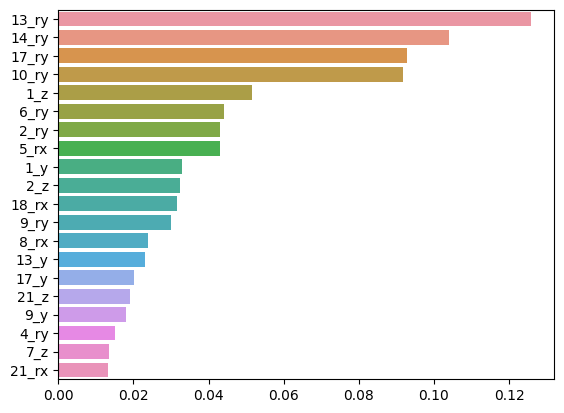

In [49]:
# Visualize feature importances of XGB
feature_series = pd.Series(data=model_xgb.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series[:20], y=feature_series.index[:20])

## 7. Export Model

In [11]:
import pickle

with open('xgb.h5', 'wb') as file:  # config  
    pickle.dump(model_xgb, file)

with open('lgbm.h5', 'wb') as file: # config   
    pickle.dump(model_lgbm, file)